In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
os.chdir('E:/Data Science/Competitions/Projects/Poverty Level Prediction')

In [2]:
df = pd.read_csv('finaldata.csv')
df.head()


,monthly_rent,rooms,has_bathroom,has_fridge,has_tablet,n_males,n_females,n_under_12,n_above_12,n_persons,...,is_overcrowded,ownership_own,ownership_rented,region_central,region_chorotega,region_huetar_alt,region_huetar_nor,region_pac_central,zone_urban,gender_male
0,190000.000000,3,1,1,0,1,0,0,1,1,...,0,0,1,1,0,0,0,0,1,1
1,135000.000000,4,1,1,1,1,0,0,1,1,...,0,0,1,1,0,0,0,0,1,1
2,192412.491466,8,1,1,0,0,1,0,1,1,...,0,1,0,1,0,0,0,0,1,0
3,180000.000000,5,1,1,1,2,2,1,3,4,...,0,0,1,1,0,0,0,0,1,1
4,180000.000000,5,1,1,1,2,2,1,3,4,...,0,0,1,1,0,0,0,0,1,0


In [3]:
df.shape

(9557, 54)

### class imbalance check

In [4]:
df['Target'].value_counts(normalize = True)

4    0.627394
2    0.167103
3    0.126504
1    0.079000
Name: Target, dtype: float64

In [5]:
df['Target'].value_counts()

4    5996
2    1597
3    1209
1     755
Name: Target, dtype: int64

##### There is a class imbalance. The extremely poor households are the minority here. Also, we have to identify such households. So, to balance the data using SMOTE

### Splitting the data

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop('Target', axis = 1)
Y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 21)

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


In [8]:
DT  = DecisionTreeClassifier(random_state = 21)

DT.fit(X_train, y_train)

yt_pred = DT.predict(X_train)
y_pred = DT.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.77      0.83      0.80       223
           2       0.78      0.81      0.80       468
           3       0.84      0.83      0.83       345
           4       0.96      0.94      0.95      1832

    accuracy                           0.90      2868
   macro avg       0.84      0.85      0.84      2868
weighted avg       0.90      0.90      0.90      2868



In [9]:
print(classification_report(y_train,yt_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       532
           2       1.00      1.00      1.00      1129
           3       1.00      1.00      1.00       864
           4       1.00      1.00      1.00      4164

    accuracy                           1.00      6689
   macro avg       1.00      1.00      1.00      6689
weighted avg       1.00      1.00      1.00      6689



The model overfits. Also, the precision, recall and f1 score for class 4 is above 0.90. thus the accuracy of 90%.

But here, we are more concerned with the accurate prediciton of class 1 which are the households that are most vulnerable. The precision, recall and f1 score for class 1 look descent, we would try to increase these scores

As we know that there is imbalance among the classes, there is a need to apply SMOTE to balance these classes and build models over it.

## Applying SMOTE 

In [10]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()

X_smote, y_smote = sm.fit_resample(X, Y)

print(y_smote.value_counts())

4    5996
3    5996
2    5996
1    5996
Name: Target, dtype: int64


## Models after applying SMOTE

In [11]:
## Model 2:

DT  = DecisionTreeClassifier(random_state = 21)

X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size = 0.3, random_state = 21)

DT.fit(X_train, y_train)

yt_pred = DT.predict(X_train)
y_pred = DT.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.88      0.91      0.89      1831
           2       0.83      0.81      0.82      1777
           3       0.86      0.86      0.86      1773
           4       0.91      0.89      0.90      1815

    accuracy                           0.87      7196
   macro avg       0.87      0.87      0.87      7196
weighted avg       0.87      0.87      0.87      7196



In [12]:
print(classification_report(y_train,yt_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4165
           2       1.00      1.00      1.00      4219
           3       1.00      1.00      1.00      4223
           4       1.00      1.00      1.00      4181

    accuracy                           1.00     16788
   macro avg       1.00      1.00      1.00     16788
weighted avg       1.00      1.00      1.00     16788



After applying SMOTE still there the precision, recall and f1 score values improved for class 1 by 10% which is a good indicator.

But still there exists high variance in the model which needs to be addressed by using some Bagging techniques.

In [13]:
## Model 3: Bagged DT 

BG_DT = BaggingClassifier(base_estimator = DT, random_state = 21)

BG_DT.fit(X_train, y_train)

yt_pred = BG_DT.predict(X_train)
y_pred = BG_DT.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.91      0.94      0.93      1831
           2       0.90      0.89      0.89      1777
           3       0.92      0.90      0.91      1773
           4       0.94      0.94      0.94      1815

    accuracy                           0.92      7196
   macro avg       0.92      0.92      0.92      7196
weighted avg       0.92      0.92      0.92      7196



In [14]:
print(classification_report(y_train,yt_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4165
           2       1.00      1.00      1.00      4219
           3       1.00      1.00      1.00      4223
           4       1.00      1.00      1.00      4181

    accuracy                           1.00     16788
   macro avg       1.00      1.00      1.00     16788
weighted avg       1.00      1.00      1.00     16788



Variance did not decrease much, need to find optimal estimators for BG_DT

In [15]:
## Model 4:
RF  = RandomForestClassifier(random_state = 21)

RF.fit(X_train, y_train)

yt_pred = RF.predict(X_train)
y_pred = RF.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.95      0.97      0.96      1831
           2       0.95      0.92      0.94      1777
           3       0.96      0.94      0.95      1773
           4       0.94      0.96      0.95      1815

    accuracy                           0.95      7196
   macro avg       0.95      0.95      0.95      7196
weighted avg       0.95      0.95      0.95      7196



In [16]:
print(classification_report(y_train,yt_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4165
           2       1.00      1.00      1.00      4219
           3       1.00      1.00      1.00      4223
           4       1.00      1.00      1.00      4181

    accuracy                           1.00     16788
   macro avg       1.00      1.00      1.00     16788
weighted avg       1.00      1.00      1.00     16788



In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

### Feature Selection

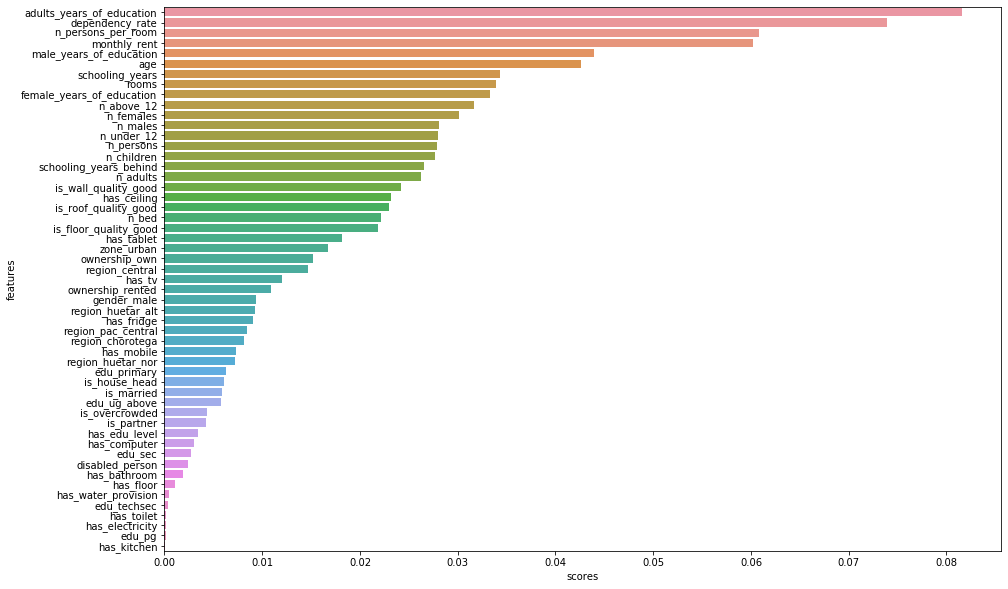

In [18]:
## 1. Feature Importance

imp_features = pd.DataFrame({'features': X_train.columns, 'scores':  RF.feature_importances_})
imp_features = imp_features.sort_values(by = 'scores', ascending = False)

plt.figure(figsize = (15,10))
sns.barplot(x = 'scores', y = 'features', data = imp_features)
plt.show()

In [19]:
## Using top 10 features from feature importance
top10 = imp_features['features'].tolist()[:10]

train = X_train[top10]

test = X_test[top10]

## Model 5:
RF  = RandomForestClassifier(random_state = 21)

RF.fit(train, y_train)

yt_pred = RF.predict(train)
y_pred = RF.predict(test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.92      0.95      0.94      1831
           2       0.92      0.87      0.90      1777
           3       0.91      0.91      0.91      1773
           4       0.93      0.95      0.94      1815

    accuracy                           0.92      7196
   macro avg       0.92      0.92      0.92      7196
weighted avg       0.92      0.92      0.92      7196



In [20]:
print(classification_report(y_train,yt_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4165
           2       1.00      1.00      1.00      4219
           3       1.00      1.00      1.00      4223
           4       1.00      1.00      1.00      4181

    accuracy                           1.00     16788
   macro avg       1.00      1.00      1.00     16788
weighted avg       1.00      1.00      1.00     16788



In [21]:
## Using top 20 features from feature importance
top20 = imp_features['features'].tolist()[:20]

train = X_train[top20]

test = X_test[top20]

## Model 6:
RF  = RandomForestClassifier(random_state = 21)

RF.fit(train, y_train)

yt_pred = RF.predict(train)
y_pred = RF.predict(test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.94      0.97      0.95      1831
           2       0.93      0.91      0.92      1777
           3       0.95      0.92      0.94      1773
           4       0.94      0.96      0.95      1815

    accuracy                           0.94      7196
   macro avg       0.94      0.94      0.94      7196
weighted avg       0.94      0.94      0.94      7196



In [22]:
print(classification_report(y_train,yt_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4165
           2       1.00      1.00      1.00      4219
           3       1.00      1.00      1.00      4223
           4       1.00      1.00      1.00      4181

    accuracy                           1.00     16788
   macro avg       1.00      1.00      1.00     16788
weighted avg       1.00      1.00      1.00     16788



In [23]:
## Using top 30 features from feature importance
top30 = imp_features['features'].tolist()[:30]

train = X_train[top30]

test = X_test[top30]

## Model 7:
RF  = RandomForestClassifier(random_state = 21)

RF.fit(train, y_train)

yt_pred = RF.predict(train)
y_pred = RF.predict(test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.95      0.98      0.97      1831
           2       0.95      0.92      0.93      1777
           3       0.95      0.94      0.95      1773
           4       0.95      0.96      0.96      1815

    accuracy                           0.95      7196
   macro avg       0.95      0.95      0.95      7196
weighted avg       0.95      0.95      0.95      7196



In [24]:
print(classification_report(y_train,yt_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4165
           2       1.00      1.00      1.00      4219
           3       1.00      1.00      1.00      4223
           4       1.00      1.00      1.00      4181

    accuracy                           1.00     16788
   macro avg       1.00      1.00      1.00     16788
weighted avg       1.00      1.00      1.00     16788



In [25]:
print(top30)

['adults_years_of_education', 'dependency_rate', 'n_persons_per_room', 'monthly_rent', 'male_years_of_education', 'age', 'schooling_years', 'rooms', 'female_years_of_education', 'n_above_12', 'n_females', 'n_males', 'n_under_12', 'n_persons', 'n_children', 'schooling_years_behind', 'n_adults', 'is_wall_quality_good', 'has_ceiling', 'is_roof_quality_good', 'n_bed', 'is_floor_quality_good', 'has_tablet', 'zone_urban', 'ownership_own', 'region_central', 'has_tv', 'ownership_rented', 'gender_male', 'region_huetar_alt']


Using top 30 features for further models as the f1score using all features and 30 features is same.

In [28]:
## RFE to find optimal number of features
from sklearn.feature_selection import RFECV

def apply_rfecv(x,y):

    RF = RandomForestClassifier(random_state=0)
    rfecv = RFECV(estimator = RF, step = 1, cv = 5, scoring = 'f1_weighted')
    rfecv.fit(x, y)
    
    print("Optimal number of features : %d" % rfecv.n_features_)
    
    rfe_features = pd.DataFrame({'features': x.columns, 'rank':rfecv.ranking_}).sort_values(by = 'rank')
    sel_features = rfe_features[rfe_features['rank']==1]['features'].to_list()
    
    return sel_features

sel_features = apply_rfecv(X_train[top30],y_train)
print(sel_features)

Optimal number of features : 27
['adults_years_of_education', 'has_tv', 'region_central', 'ownership_own', 'zone_urban', 'has_tablet', 'is_floor_quality_good', 'n_bed', 'is_roof_quality_good', 'has_ceiling', 'is_wall_quality_good', 'n_adults', 'schooling_years_behind', 'n_children', 'n_under_12', 'n_males', 'n_females', 'n_above_12', 'female_years_of_education', 'rooms', 'schooling_years', 'age', 'male_years_of_education', 'monthly_rent', 'n_persons_per_room', 'dependency_rate', 'n_persons']


In [29]:
## Using features from RFE

train = X_train[sel_features]

test = X_test[sel_features]

## Model 8:
RF  = RandomForestClassifier(random_state = 21)

RF.fit(train, y_train)

yt_pred = RF.predict(train)
y_pred = RF.predict(test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.96      0.97      0.96      1831
           2       0.94      0.93      0.93      1777
           3       0.96      0.94      0.95      1773
           4       0.95      0.97      0.96      1815

    accuracy                           0.95      7196
   macro avg       0.95      0.95      0.95      7196
weighted avg       0.95      0.95      0.95      7196



In [30]:
print(classification_report(y_train,yt_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4165
           2       1.00      1.00      1.00      4219
           3       1.00      1.00      1.00      4223
           4       1.00      1.00      1.00      4181

    accuracy                           1.00     16788
   macro avg       1.00      1.00      1.00     16788
weighted avg       1.00      1.00      1.00     16788



## Cross validation

In [33]:
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold

In [33]:
## using top 30 features

X1 = X_smote[top30]
Y1 = y_smote

names = ['DT', 'BG_DT', 'RF']
models = [DT, RF, BG_DT]

for model,name in zip(models,names):
    kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 21)
    cv_results = cross_validate(model, X1, Y1, cv = kfold, scoring = 'f1_weighted', return_train_score = True)
    print(name)
    print(cv_results['train_score'])
    print(cv_results['test_score'])

DT
[1. 1. 1. 1. 1.]
[0.90317649 0.88887258 0.89333336 0.88352258 0.88132998]
BG_DT
[1.         0.99994788 1.         1.         1.        ]
[0.95845228 0.96372499 0.95888273 0.96182074 0.95798077]
RF
[0.99791515 0.99791523 0.99843626 0.99859283 0.99859287]
[0.9399686  0.93379994 0.93321832 0.93995978 0.93372024]


#### Still there is some amount of overfitting, so need to tune the parameters of Random Forest Model

In [34]:
## using features from RFE

X1 = X_smote[sel_features]
Y1 = y_smote

names = ['DT', 'BG_DT', 'RF']
models = [DT, RF, BG_DT]

for model,name in zip(models,names):
    kfold = KFold(n_splits = 5, shuffle = True, random_state = 21)
    cv_results = cross_validate(model, X1, Y1, cv = kfold, scoring = 'f1_weighted', return_train_score = True)
    print(name)
    print(cv_results['train_score'])
    print(cv_results['test_score'])

DT
[1. 1. 1. 1. 1.]
[0.88650739 0.88155403 0.88641496 0.89128126 0.90190254]
BG_DT
[1. 1. 1. 1. 1.]
[0.96066761 0.95807001 0.96011546 0.95991685 0.95846027]
RF
[0.9983321  0.99760262 0.99796714 0.99822805 0.99833241]
[0.92262014 0.92626604 0.92632019 0.92893181 0.93118683]


## Hyperparameter Tuning using 30 features

In [ ]:
X1 = X_smote[top30]
Y1 = y_smote

X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size = 0.3, random_state = 21)


In [ ]:
## parameters for RF
max_depth = np.arange(2,10)
min_samples_split = np.arange(10,30,3)
min_samples_leaf = np.arange(10,40,3)
n_estimators = np.arange(90,110,7)

params = {
          'max_depth': max_depth,
          'min_samples_split': min_samples_split,
          'min_samples_leaf': min_samples_leaf,
          'n_estimators': n_estimators
         }

RF  = RandomForestClassifier(random_state = 21)

rscv = RandomizedSearchCV(RF, params, scoring = 'f1_weighted', cv = 5, return_train_score = True)
results = rscv.fit(X_train,y_train)
results.best_params_

In [ ]:

est = results.best_estimator_

est.fit(X_train, y_train)

yt_pred = est.predict(X_train)
y_pred = est.predict(X_test)

print(classification_report(y_test,y_pred))

In [ ]:
print(classification_report(y_train,yt_pred))

#### From the above hyper parameter tuning, the parameters are as follows:

1. {'n_estimators': 67, 'min_samples_split': 25, 'min_samples_leaf': 13, 'max_depth': 9} - 78 | 78

2. {'n_estimators': 67, 'min_samples_split': 25, 'min_samples_leaf': 16, 'max_depth': 8} - 74 | 74

3. {'n_estimators': 88, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 9} - 78 | 80

4. {'n_estimators': 97, 'min_samples_split': 16, 'min_samples_leaf': 13, 'max_depth': 8} - 74 | 75


The reuslts from these parameters are not showing any kind of overfitting. Here, consider the parameters in point 3 for RF

In [ ]:
## parameters for DT
max_depth = np.arange(2,10)
min_samples_split = np.arange(5,30,5)
min_samples_leaf = np.arange(5,40,5)

params = {
          'max_depth': max_depth,
          'min_samples_split': min_samples_split,
          'min_samples_leaf': min_samples_leaf
         }

DT  = DecisionTreeClassifier(random_state = 21)

rscv = RandomizedSearchCV(DT, params, scoring = 'f1_weighted', cv = 5, return_train_score = True)
results = rscv.fit(X_train,y_train)
results.best_params_

In [ ]:

est = results.best_estimator_

est.fit(X_train, y_train)

yt_pred = est.predict(X_train)
y_pred = est.predict(X_test)

print(classification_report(y_test,y_pred))

print('\nTrain: ')
print(classification_report(y_train,yt_pred))

#### From the above hyper parameter tuning, the parameters are as follows:

1. {'min_samples_split': 28, 'min_samples_leaf': 16, 'max_depth': 9} - 69 | 70

2. {'min_samples_split': 24, 'min_samples_leaf': 37, 'max_depth': 9} - 67 | 68

3. {'min_samples_split': 18, 'min_samples_leaf': 11, 'max_depth': 8} - 67 | 66

4. {'min_samples_split': 25, 'min_samples_leaf': 30, 'max_depth': 9} - 67 | 69


The reuslts from these parameters are not showing any kind of overfitting. Here we can consider the parameters in point 1 for DT

In [40]:
## parameter for BG_DT
n_estimators = np.arange(28, 35)

params = {
          'n_estimators': n_estimators
         }

BG_DT = BaggingClassifier(base_estimator = DT, random_state = 21)

rscv = RandomizedSearchCV(BG_DT, params, scoring = 'f1_weighted', cv = 5, return_train_score = True)
results = rscv.fit(X_train,y_train)
results.best_params_

C:\Users\Ankita\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


{'n_estimators': 47}

In [41]:
est = results.best_estimator_

est.fit(X_train, y_train)

yt_pred = est.predict(X_train)
y_pred = est.predict(X_test)

print(classification_report(y_test,y_pred))

print('\nTrain: ')
print(classification_report(y_train,yt_pred))

              precision    recall  f1-score   support

           1       0.95      0.96      0.95      1831
           2       0.94      0.92      0.93      1777
           3       0.94      0.94      0.94      1773
           4       0.95      0.96      0.96      1815

    accuracy                           0.94      7196
   macro avg       0.94      0.94      0.94      7196
weighted avg       0.94      0.94      0.94      7196


Train: 
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4165
           2       1.00      1.00      1.00      4219
           3       1.00      1.00      1.00      4223
           4       1.00      1.00      1.00      4181

    accuracy                           1.00     16788
   macro avg       1.00      1.00      1.00     16788
weighted avg       1.00      1.00      1.00     16788



#### From the above hyper parameter tuning, the parameters are as follows:

1. {'n_estimators': 28} - 95 | 1
2. {'n_estimators': 47} - 95 | 1


The reuslts from these parameters are showing overfitting.

In [43]:
## Final Models after tuning

finalRF = RandomForestClassifier(n_estimators = 97, min_samples_split = 16, min_samples_leaf = 13, 
                                 max_depth = 8, random_state = 21)


finalDT = DecisionTreeClassifier(min_samples_split = 28, min_samples_leaf = 16, max_depth = 9, random_state = 21)


finalBG_DT = BaggingClassifier(base_estimator = DT, n_estimators = 28, random_state = 21)

In [44]:
X1 = X_smote[top30]
Y1 = y_smote

names = ['Tuned BGDT', 'Tuned DT', 'Tuned RF']
models = [finalBG_DT, finalDT, finalRF]

for model,name in zip(models, names):
    kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 21)
    cv_results = cross_validate(model, X1, Y1, cv = kfold, scoring = 'f1_weighted', return_train_score = True)
    print('\n')
    print(name)
    print(cv_results['train_score'], cv_results['train_score'].mean())
    print(cv_results['test_score'], cv_results['test_score'].mean())



Tuned BGDT
[0.99979151 0.99979151 0.99984364 0.99994788 0.99973941] 0.9998227928772394
[0.95412762 0.94765151 0.94676448 0.94956698 0.94476966] 0.9485760491346868


Tuned DT
[0.65277268 0.65624873 0.6554594  0.64989171 0.64951071] 0.652776647049163
[0.63150923 0.62439393 0.63954545 0.601159   0.61396014] 0.6221135515215729


Tuned RF
[0.71762586 0.71657068 0.71413054 0.71119855 0.71959936] 0.715824998105345
[0.70406869 0.68375401 0.68811851 0.68518918 0.68800172] 0.6898264235389168


## Hyperparameter Tuning using RFE features


In [36]:

X1 = X_smote[sel_features]
Y1 = y_smote

X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size = 0.3, random_state = 21)


In [37]:
## parameters for RF
max_depth = np.arange(2,10)
min_samples_split = np.arange(10,30,3)
min_samples_leaf = np.arange(10,40,3)
n_estimators = np.arange(90,110,7)

params = {
          'max_depth': max_depth,
          'min_samples_split': min_samples_split,
          'min_samples_leaf': min_samples_leaf,
          'n_estimators': n_estimators
         }

RF  = RandomForestClassifier(random_state = 21)

rscv = RandomizedSearchCV(RF, params, scoring = 'f1_weighted', cv = 5, return_train_score = True)
results = rscv.fit(X_train,y_train)
print(results.best_params_)


est = results.best_estimator_

est.fit(X_train, y_train)

yt_pred = est.predict(X_train)
y_pred = est.predict(X_test)

print(classification_report(y_test,y_pred))

print('train')
print(classification_report(y_train,yt_pred))

{'n_estimators': 104, 'min_samples_split': 22, 'min_samples_leaf': 13, 'max_depth': 9}
              precision    recall  f1-score   support

           1       0.73      0.81      0.77      1831
           2       0.74      0.60      0.66      1777
           3       0.67      0.71      0.69      1773
           4       0.78      0.80      0.79      1815

    accuracy                           0.73      7196
   macro avg       0.73      0.73      0.73      7196
weighted avg       0.73      0.73      0.73      7196

train
              precision    recall  f1-score   support

           1       0.76      0.82      0.79      4165
           2       0.79      0.65      0.71      4219
           3       0.71      0.76      0.73      4223
           4       0.80      0.83      0.82      4181

    accuracy                           0.76     16788
   macro avg       0.77      0.76      0.76     16788
weighted avg       0.77      0.76      0.76     16788



In [38]:
## Final Models after tuning

rfe_finalRF = RandomForestClassifier(n_estimators = 104, min_samples_split = 22, min_samples_leaf = 13, 
                                 max_depth = 9, random_state = 21)

X1 = X_smote[sel_features]
Y1 = y_smote

names = ['Tuned RFE + RF']
models = [rfe_finalRF]

for model,name in zip(models, names):
    kfold = KFold(n_splits = 5, shuffle = True, random_state = 21)
    cv_results = cross_validate(model, X1, Y1, cv = kfold, scoring = 'f1_weighted', return_train_score = True)
    print('\n')
    print(name)
    print(cv_results['train_score'], cv_results['train_score'].mean())
    print(cv_results['test_score'], cv_results['test_score'].mean())



Tuned RFE + RF
[0.76036285 0.76248428 0.75655342 0.76177738 0.75972492] 0.7601805699106057
[0.72591178 0.72752914 0.71955311 0.73113837 0.72149455] 0.7251253892571581


From all the models built, Random Forest with RFE resulting in 27 features gives the best results, that is, f1 score of 72% on the test data with less variance. Thus, it is the best model for the data